In [1]:
import ee
import geemap
import xarray as xr
import wxee

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()
wxee.Initialize()

In [4]:
bbox = ee.Geometry.Polygon(
    [[
        [-84.2, 9.8],  # Lower left corner
        [-84.2, 10],   # Upper left corner
        [-83.9, 10],   # Upper right corner
        [-83.9, 9.8],  # Lower right corner
        [-84.2, 9.8]   # Closing the polygon by repeating the first point
    ]]
)

In [5]:
# Load the HydroSHEDS Flow Direction dataset and the specified Flow Accumulation dataset
flow_direction = ee.Image('WWF/HydroSHEDS/03DIR').clip(bbox)

crs = flow_direction.projection().crs()
scale = 30

# Downsample to 30m resolution using bicubic interpolation
flow_direction_30m = flow_direction.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

flow_accumulation_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/base-network-layers/flow_accumulation").filterBounds(bbox)
flow_accumulation = flow_accumulation_collection.first().select('b1').clip(bbox)
flow_accumulation_30m = flow_accumulation.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

stream_dist_proximity_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/stream-outlet-distance/stream_dist_proximity").filterBounds(bbox)
stream_dist_proximity = stream_dist_proximity_collection.first().select('b1').clip(bbox)
stream_dist_proximity_30m = stream_dist_proximity.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

spi_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/spi").filterBounds(bbox)
spi_image = spi_collection.first().select('b1').clip(bbox)
spi_image_30m = spi_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

sti_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/sti").filterBounds(bbox)
sti_image = sti_collection.first().select('b1').clip(bbox)
sti_image_30m = sti_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

# compound topographic index, aka topographic wetness index
cti_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/cti").filterBounds(bbox)
cti_image = cti_collection.first().select('b1').clip(bbox)
cti_image_30m = cti_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

vis_params_dir = {'min': 0, 'max': 360, 'palette': ['blue', 'green', 'red']}
vis_params_stream_dist_proximity = {
    'palette': ['white', 'blue'],  # Assuming water proximity might be visualized from white (far) to blue (near)
    'min': 0,
    'max': 250  # You may want to adjust this based on the actual range of the data
}
vis_params_acc = {'min': 0, 'max': 360, 'palette': ['00FF00', '0000FF']}
vis_params_spi = {'min': 0, 'max': 22, 'palette': ['ffff00', 'ff0000']}
vis_params_sti = {'min': 0, 'max': 20, 'palette': ['00ffff', '0000ff']}
vis_params_cti = {'min': 0, 'max': 20, 'palette': ['white', 'brown']}

dem = ee.Image('USGS/SRTMGL1_003').clip(bbox)
vis_params = {
    'min': 0,
    'max': 4000,
    'palette': 'terrain',
}

slope = ee.Terrain.slope(dem)
slope_vis_params = {
    'min': 0,
    'max': 60,
    'palette': ['black', 'blue', 'green', 'yellow', 'orange', 'red']
}


# aspect
aspect_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/aspect").filterBounds(bbox)
aspect_image = aspect_collection.first().select('b1').clip(bbox)
aspect_image_30m = aspect_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)
vis_params_aspect = {'min': 0, 'max': 100, 'palette': ['white', 'orange']}

# tpi: topographic position index
tpi_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/tpi").filterBounds(bbox)
tpi_image = tpi_collection.first().select('b1').clip(bbox)
tpi_image_30m = tpi_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)
vis_params_tpi = {'min': 0, 'max': 50, 'palette': ['white', 'purple']}

# tri: terrain ruggedness index
tri_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/tri").filterBounds(bbox)
tri_image = tri_collection.first().select('b1').clip(bbox)
tri_image_30m = tri_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)
vis_params_tri = {'min': 0, 'max': 50, 'palette': ['white', 'green']}

pcurv_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/pcurv").filterBounds(bbox)
pcurv_image = pcurv_collection.first().select('b1').clip(bbox)
pcurv_image_30m = pcurv_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)
vis_params_pcurv = {'min': -50, 'max': -5, 'palette': ['white', 'red']}


tcurv_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/tcurv").filterBounds(bbox)
tcurv_image = tcurv_collection.first().select('b1').clip(bbox)
tcurv_image_30m = tcurv_image.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)
vis_params_tcurv  = {'min': -50, 'max': -5, 'palette': ['white', 'yellow']}

landcover = ee.Image("ESA/WorldCover/v100/2020").clip(bbox)
hwsd2 = ee.Image("projects/sat-io/open-datasets/FAO/HWSD_V2_SMU").select('HWSD2_ID').clip(bbox)
ghsl = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_C").filterBounds(bbox).first().select('built_characteristics').clip(bbox)

In [6]:
# Create a map
Map = geemap.Map()
Map.add("basemap_selector")
Map.add("layer_manager")

# Center the map on San Jose, Costa Rica
Map.setCenter(-84.0833, 9.9333, 10)

# Add the flow direction and accumulation layers to the map
Map.addLayer(flow_direction_30m, vis_params_dir, 'Flow Direction 30m')
Map.addLayer(flow_accumulation_30m, vis_params_acc, 'Flow Accumulation 30m', True)
Map.addLayer(stream_dist_proximity_30m, vis_params_stream_dist_proximity, 'Stream Dist. Prox. 30m')
Map.addLayer(spi_image_30m, vis_params_spi, 'Stream Power Index 30m')
Map.addLayer(tpi_image_30m, vis_params_tpi, 'Topographic Position Index 30m')
Map.addLayer(tri_image_30m, vis_params_tri, 'Terrain Roughness Index 30m')
Map.addLayer(sti_image_30m, vis_params_sti, 'Sediment Transport Index 30m')
Map.addLayer(cti_image_30m, vis_params_cti, 'Compound Topographic Index 30m')
Map.addLayer(landcover, {}, 'ESA WorldCover 2020')
Map.addLayer(ghsl, {}, 'Multitemporal Built-up Characteristics')
Map.addLayer(pcurv_image_30m.log(), vis_params_pcurv, "Planar Curvature 30m") # needs to be log-transofmred for clear viz
Map.addLayer(tcurv_image_30m.log(), vis_params_tcurv, "Tangential Curvature 30m") # needs to be log-transformed for clear viz
Map.addLayer(hwsd2.randomVisualizer(), {}, 'Soil 1km')
# Map.add_layer(dem, vis_params, 'SRTM DEM')
Map.addLayer(slope, slope_vis_params, 'Slope')
Map.addLayer(aspect_image_30m, vis_params_aspect, "Aspect 30m")

# Display the map
Map

Map(center=[9.9333, -84.0833], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [7]:
# Combine layers into a single multi-band image
raster_stack = ee.Image.cat([
    flow_direction_30m,
    flow_accumulation_30m,
    stream_dist_proximity_30m,
   # spi_image_30m,
    #tpi_image_30m,
    #tri_image_30m,
    sti_image_30m,
    cti_image_30m,
    landcover,
    ghsl,
    pcurv_image_30m,
    tcurv_image_30m,
    hwsd2,
    dem,
    slope,
    aspect_image_30m
])

arr = raster_stack.wx.to_xarray(scale=scale, crs=crs)

Downloading:   0%|          | 0.00/20.5M [00:00<?, ?iB/s]

In [8]:
arr

<xarray.Dataset>
Dimensions:                (time: 1, x: 1114, y: 743)
Coordinates:
  * time                   (time) datetime64[ns] 2014-12-04T22:33:07
  * x                      (x) float64 -84.2 -84.2 -84.2 ... -83.9 -83.9 -83.9
  * y                      (y) float64 10.0 10.0 9.999 9.999 ... 9.801 9.8 9.8
    spatial_ref            int32 0
Data variables: (12/13)
    b1                     (time, y, x) float32 1.0 1.0 1.0 2.0 ... 1.0 1.0 1.0
    b1_1                   (time, y, x) float32 0.01714 0.01689 ... 8.99 8.999
    b1_2                   (time, y, x) float64 273.0 269.0 ... -11.0 -11.0
    b1_3                   (time, y, x) float64 15.0 17.0 ... 1.02e+03 950.0
    b1_4                   (time, y, x) float64 -7.563e+07 ... 5.332e+08
    Map                    (time, y, x) float32 50.0 50.0 50.0 ... 10.0 10.0
    ...                     ...
    b1_5                   (time, y, x) float32 -7.682e-05 ... -0.0004578
    b1_6                   (time, y, x) float32 0.0001249 ... -0.006567
    HWSD2_ID               (time, y, x) float32 1.61e+04 1.61e+04 ... 1.61e+04
    elevation              (time, y, x) float32 932.0 935.0 ... 1.24e+03
    slope                  (time, y, x) float32 nan nan nan nan ... nan nan nan
    b1_7                   (time, y, x) float32 197.4 197.2 ... 90.96 91.84
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

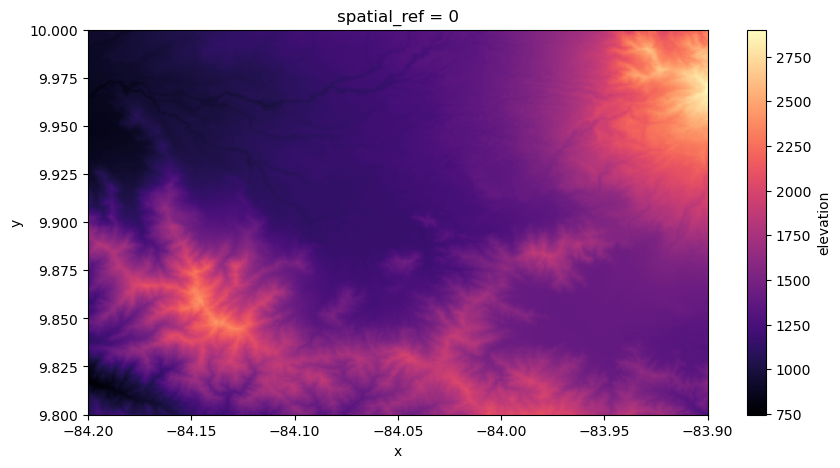

In [9]:
arr.elevation.max("time").plot(figsize=(10, 5), cmap="magma")